In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

from sim_handling import Simulation,loadSim
from diffusionstuff7 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [9]:
%matplotlib widget

This notebook contains code to test the internal math of the ice continuum model, ensuring it is behaving as expected.

In [3]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (500,20), rtol=1e-12)
test_2d_asym.layermax = 20
test_2d_asym.center_reduction = 0.25
test_2d_asym.deltaT *= 5 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

In [4]:
test_2d_asym.results()

breaking because reached max number of layers grown


{None: None,
 'y': [array([[[1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          ...,
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.],
          [1., 1., 1., ..., 1., 1., 1.]],
  
         [[2., 2., 2., ..., 2., 2., 2.],
          [2., 2., 2., ..., 2., 2., 2.],
          [2., 2., 2., ..., 2., 2., 2.],
          ...,
          [2., 2., 2., ..., 2., 2., 2.],
          [2., 2., 2., ..., 2., 2., 2.],
          [2., 2., 2., ..., 2., 2., 2.]]]),
  array([[[1.01346544, 1.01346544, 1.01346544, ..., 1.01346544,
           1.01346544, 1.01346544],
          [1.01346291, 1.01346291, 1.01346291, ..., 1.01346291,
           1.01346291, 1.01346291],
          [1.01346038, 1.01346038, 1.01346038, ..., 1.01346038,
           1.01346038, 1.01346038],
          ...,
          [1.01346038, 1.01346038, 1.01346038, ..., 1.01346038,
           1.01346038, 1.01346038],
          [1.01346291, 1.01346291, 1.0

In [35]:
num_steps = len(test_2d_asym.results()['t'])


Fliq0,Ntot = test_2d_asym.results()['y'][num_steps-3]
print(np.asarray(test_2d_asym.results()['y']).shape)
print(num_steps)


Nbar = test_2d_asym._extra_vars['Nbar']
Nstar = test_2d_asym._extra_vars['Nstar']
delta = (Fliq0 - (Nbar - Nstar))/(2*Nstar)

(2998, 2, 500, 20)
2998


In [62]:
#f2d code
import numpy as np
#import math
from numba import njit, float64, types
import diffusionstuff7 as ds

@njit("f8[:](f8[:],f8,f8[:],i8[:],f8[:,:])",parallel=True)
def f2d(y, t, float_params, int_params, sigmastep):
    """ 2D version of f1d """

    # diffusion = True

    # unpack parameters
    Nbar, Nstar, sigma0, deprate, DoverdeltaX2 = float_params 
    niter, nx, ny = int_params

    # unpack current values of y
    Fliq0, Ntot0 = np.reshape(np.ascontiguousarray(y),(types.int32(2),types.int32(nx),types.int32(ny)))
    
    # Deposition
    delta = (Fliq0 - (Nbar - Nstar))/(2*Nstar)

    #PRINT ACROSS X
    # print('printing fliq...')
    # print(Fliq0[:,5])
    # print('printing ntot...')
    # print(Ntot0[:,5])
    # print('printing delta...')
    # print(delta[:,5])
    #print('Fliq0: ', Fliq0)
    #print('Nbar - Nstar: ', Nbar - Nstar)
    #print('delta: ',delta)
    sigD = (sigmastep - delta * sigma0)/(1+delta*sigma0)
    print('sigma0: ',sigma0)


    #print('sigD: ',sigD)
    depsurf = deprate * sigD
    #print('depsurf quartersection: ',depsurf[:depsurf.shape[0]//2,:depsurf.shape[1]//2]) #TODO
    dFliq0_dt = ds.getdNliq_dNtot_2d_array(Ntot0,Nstar,Nbar,niter)*depsurf

    dNtot_dt = depsurf

    # if diffusion:
    # Diffusion
    dy =  np.reshape(np.ascontiguousarray( ds.diffuse_2d(t, np.reshape(np.ascontiguousarray(Fliq0),nx*ny), DoverdeltaX2, np.array((nx,ny))) ),  (nx,ny))
    # Combined
    dFliq0_dt += dy
    dNtot_dt += dy

    # Package for output
    derivs = np.reshape(np.stack((dFliq0_dt,dNtot_dt,delta,sigD,depsurf,dy),axis=0),6*nx*ny)
    return derivs

In [63]:
#set up sigmastep and call f2d
sigma = ds.getsigmastep_2d(test_2d_asym.x,test_2d_asym.y, test_2d_asym.center_reduction, test_2d_asym.sigmastepmax) # supersaturation

#pack the float and int parameters
from numba.types import int32,int64
if test_2d_asym.dimension >= 0:
    Nbar = test_2d_asym.float_params['Nbar']
    Nstar = test_2d_asym.float_params['Nstar']
    sigma0 = test_2d_asym.float_params['sigma0']
    deprate = test_2d_asym.float_params['deprate']

    niter = test_2d_asym.int_params['niter']
if test_2d_asym.dimension == 0:
    sigmastepmax = test_2d_asym.float_params['sigmastepmax']
    packed_float_params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])#in the order f1d expects
if test_2d_asym.dimension >= 1:
    DoverdeltaX2 = test_2d_asym.float_params['DoverdeltaX2']
    nx = test_2d_asym.int_params['nx']

    # Bundle parameters for ODE solver
    packed_float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
    packed_int_params = np.array(list(map(int32,[niter,nx])))#f1d expects int32s
if test_2d_asym.dimension == 2:
    #DoverdeltaY2 = test_2d_asym.float_params['DoverdeltaY2'] #unused
    ny = test_2d_asym.int_params['ny']
    
    #packed_float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
    packed_int_params = np.array(list(map(int64,[niter,nx,ny]))) # sigmastep math in f2d in diffusionstuff7 requires int64

derivs = f2d(np.reshape(test_2d_asym.results()['y'][num_steps-3],np.prod(np.shape(test_2d_asym.results()['y'][num_steps-3]))),test_2d_asym.results()['t'][num_steps-3],packed_float_params,packed_int_params, sigma)
Fliq,Ntot,delta,sigD,depsurf,dy = np.reshape(derivs,(6,nx,ny))

sigma0:  0.19


In [ ]:
our_y_val = 7

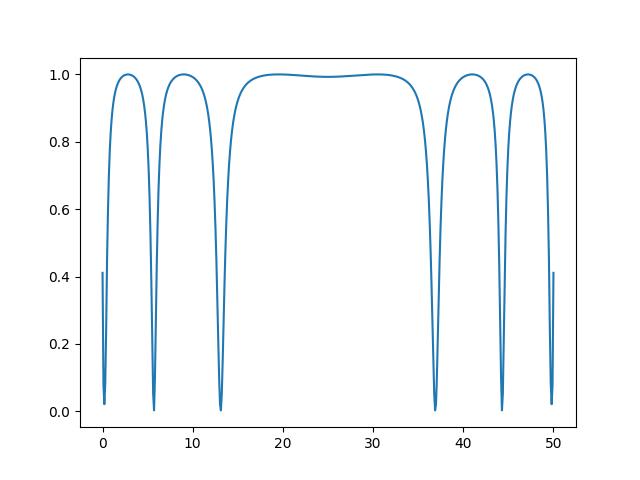

In [57]:
#plot delta (goes from 0 to 1, representing microsurfaces 1 and 2)
plt.figure()
plt.plot(test_2d_asym.x,delta[:,our_y_val])
plt.show()

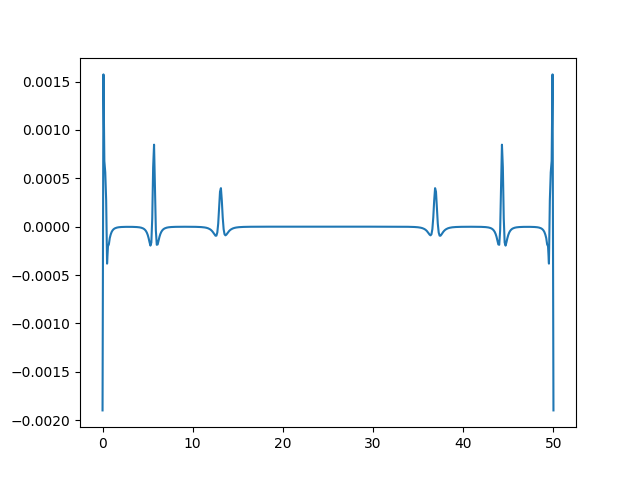

-0.0019003331442814936


In [65]:
#plot dy 
plt.figure()
plt.plot(test_2d_asym.x,dy[:,our_y_val])
plt.show()
print(dy[0,our_y_val])

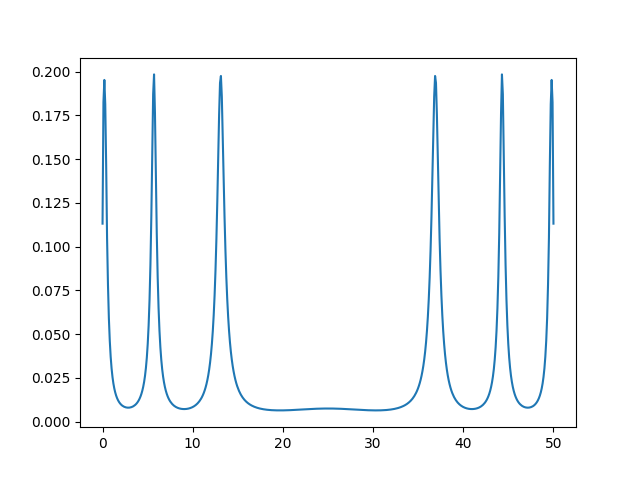

In [54]:
#plot sigD
plt.figure()
plt.plot(test_2d_asym.x,sigD[:,our_y_val])
plt.show()

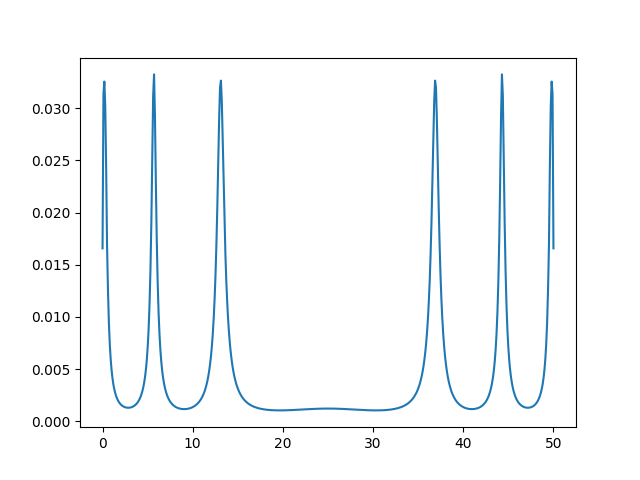

In [55]:
#plot depsurf, effect of vapor-to-liquid  (condensation)
plt.figure()
plt.plot(test_2d_asym.x,depsurf[:,our_y_val])
plt.show()

(500, 20) (500, 20)


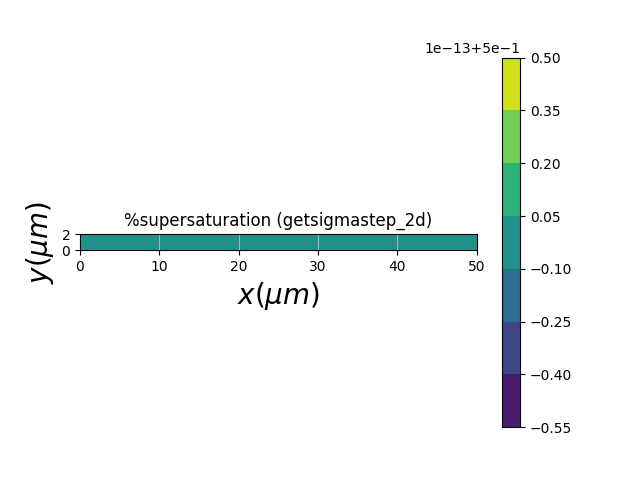

In [10]:
#countour plot of sigmastep 2d
ygrid,xgrid = np.meshgrid(test_2d_asym.y,test_2d_asym.x)

fig,ax = plt.subplots()
CS = ax.contourf(xgrid,ygrid,delta)
#CS = ax.contourf(xgrid,ygrid,xgrid) #graph x
#CS = ax.contourf(xgrid,ygrid,ygrid) #graph y
ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
plt.grid(True)
plt.gca().set_aspect('equal')
fig.colorbar(CS)
plt.title('%supersaturation (getsigmastep_2d)')
print(xgrid.shape,ygrid.shape)